### 필요 라이브러리 import

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import seaborn as sns

In [24]:
# 한글 깨짐 방지
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False 

## 데이터 전처리 및 시각화 진행
필수 데이터셋으로 '시군구/합계출산율, 모의 연령별 출산율' 사용

### 출산율 변화 시각화

In [25]:
file1 = 'data/시군구_합계출산율__모의_연령별_출산율_20250507231455.xlsx'
file2 = 'data/시군구_합계출산율__모의_연령별_출산율_20250517110743.xlsx'
sheet1 = pd.read_excel(file1, sheet_name='데이터')
sheet2 = pd.read_excel(file2, sheet_name='데이터')

cols_2023 = ['시군구별', 'total_fertility_rate', 'age_15_19', 'age_20_24', 'age_25_29', 'age_30_34', 'age_35_39', 'age_40_44', 'age_45_49']
gyeonggi_2023 = sheet1.iloc[1:].copy()
gyeonggi_2023.columns = cols_2023
gyeonggi_2023 = gyeonggi_2023[gyeonggi_2023['시군구별'].str.strip() == '경기도']
gyeonggi_2023.iloc[:, 1:] = gyeonggi_2023.iloc[:, 1:].astype(float)

/var/folders/tc/bgnk43vs26zch2nqk5w8vj940000gn/T/ipykernel_6322/97405248.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  tfr = float(sheet2.loc[sheet2['시군구별'].str.strip() == '경기도', base_col].values)
/var/folders/tc/bgnk43vs26zch2nqk5w8vj940000gn/T/ipykernel_6322/97405248.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  val = float(sheet2.loc[sheet2['시군구별'].str.strip() == '경기도', col_name].values)
/var/folders/tc/bgnk43vs26zch2nqk5w8vj940000gn/T/ipykernel_6322/97405248.py:15: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your arr

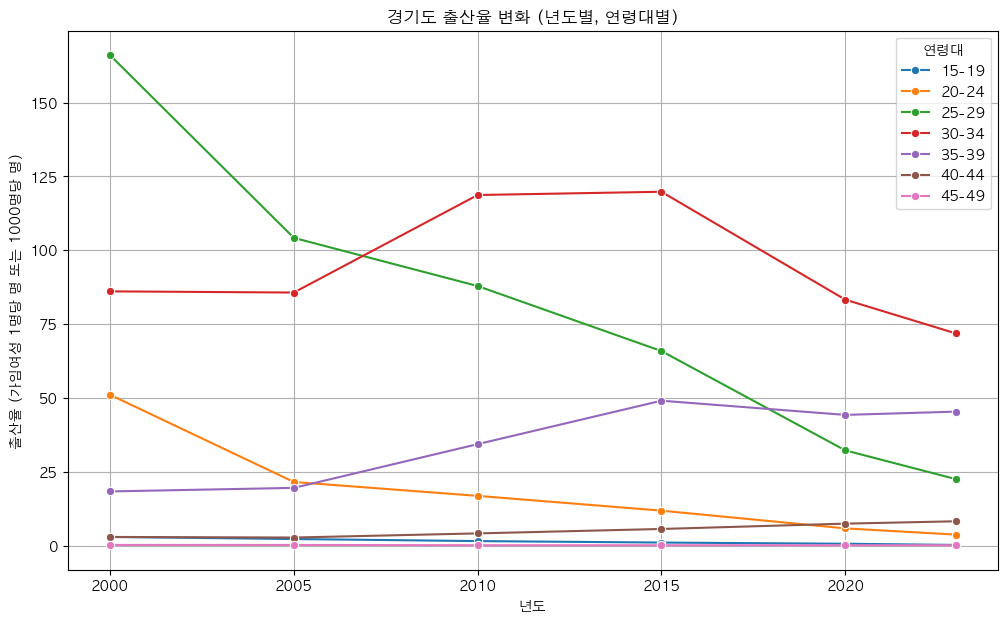

In [26]:
# 연령대 별 출산율 시각화
years = [2000, 2005, 2010, 2015, 2020]
age_groups = ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49']
rows = []
for year in years:
    base_col = str(year)
    tfr = float(sheet2.loc[sheet2['시군구별'].str.strip() == '경기도', base_col].values)
    rows.append({'year': year, 'age_group': 'total', 'fertility_rate': tfr})
    for i, age in enumerate(age_groups):
        col_name = f'{base_col}.{i+1}'
        val = float(sheet2.loc[sheet2['시군구별'].str.strip() == '경기도', col_name].values)
        rows.append({'year': year, 'age_group': age, 'fertility_rate': val})


rows.append({'year': 2023, 'age_group': 'total', 'fertility_rate': float(gyeonggi_2023['total_fertility_rate'].values)})
for age, col in zip(age_groups, cols_2023[2:]):
    rows.append({'year': 2023, 'age_group': age, 'fertility_rate': float(gyeonggi_2023[col].values)})

fertility_df = pd.DataFrame(rows)

fertility_no_total = fertility_df[fertility_df['age_group'] != 'total']
pivot_df = fertility_no_total.pivot(index='age_group', columns='year', values='fertility_rate')
pivot_df.reset_index(inplace=True)

# 전처리 데이터 새로 저장
pivot_df.to_excel('data/경기도_연령대별_출산율.xlsx', index=False)

plt.figure(figsize=(12, 7))
sns.lineplot(
    data=fertility_no_total,
    x='year',
    y='fertility_rate',
    hue='age_group',
    marker='o'
)
plt.title('경기도 출산율 변화 (년도별, 연령대별)')
plt.xlabel('년도')
plt.ylabel('출산율 (가임여성 1명당 명 또는 1000명당 명)')
plt.legend(title='연령대')
plt.grid(True)
plt.show()

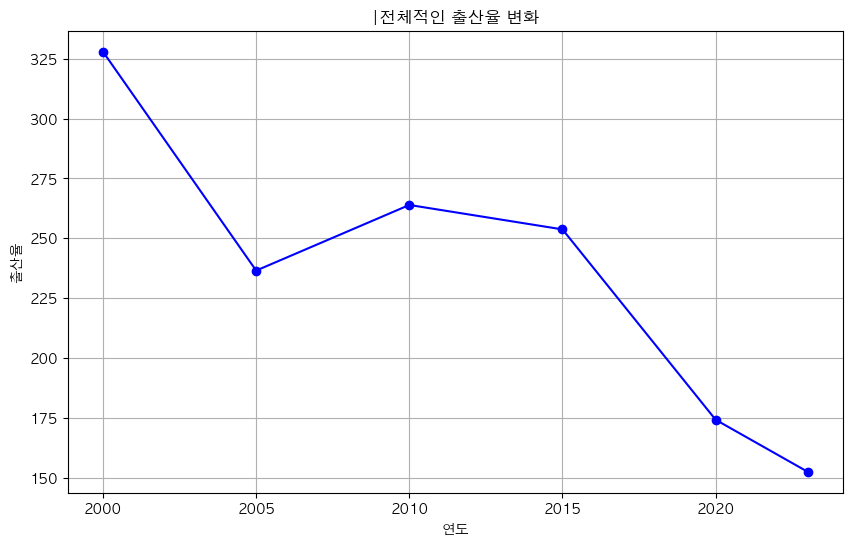

In [33]:
# 전체적인 출산율 변화 시각화
birth_data = pd.read_excel('data/경기도_연령대별_출산율.xlsx')
birth_data.rename(columns={birth_data.columns[0]: 'age_group'}, inplace=True)
years = birth_data.columns[1:]
total_birth_rate = birth_data[years].sum(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(years, total_birth_rate, marker='o', linestyle='-', color='blue')
plt.title('|전체적인 출산율 변화')
plt.xlabel('연도')
plt.ylabel('출산율')
plt.grid(True)
plt.show()

### 혼인율 변화 시각화

In [34]:
df = pd.read_excel('data/시도_성_연령별_혼인율_20250517120018.xlsx', sheet_name='데이터')
df = df.drop(0).reset_index(drop=True)
df['시도별'] = df['시도별'].fillna(method='ffill')

gyeonggi = df[df['시도별'] == '경기도'].reset_index(drop=True)

age_groups = gyeonggi['연령별'].tolist()
years = [2000, 2005, 2010, 2015, 2020, 2023]

# 연령대별 혼인율 평균(남편+아내)/2 계산
age_rate_dict = {}
for idx, age in enumerate(age_groups):
    rates = []
    for y in years:
        h = float(gyeonggi.loc[idx, f'{y}'])
        w = float(gyeonggi.loc[idx, f'{y}.1'])
        avg = (h + w) / 2
        rates.append(avg)
    age_rate_dict[age] = rates

# 전처리 데이터 새로 저장
age_rate_df = pd.DataFrame(age_rate_dict, index=years).T
age_rate_df.to_excel('data/경기도_연령대별_혼인율.xlsx')

/var/folders/tc/bgnk43vs26zch2nqk5w8vj940000gn/T/ipykernel_6322/325164980.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['시도별'] = df['시도별'].fillna(method='ffill')


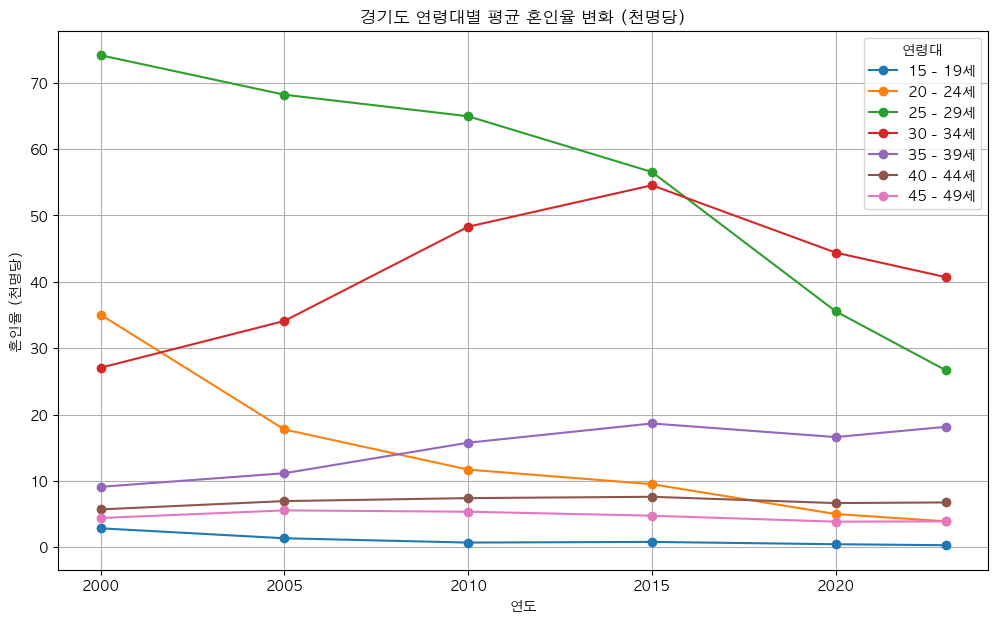

In [35]:
# 시각화
plt.figure(figsize=(12, 7))
for age, rates in age_rate_dict.items():
    plt.plot(years, rates, marker='o', label=age)

plt.title('경기도 연령대별 평균 혼인율 변화 (천명당)')
plt.xlabel('연도')
plt.ylabel('혼인율 (천명당)')
plt.legend(title='연령대')
plt.grid(True)
plt.show()

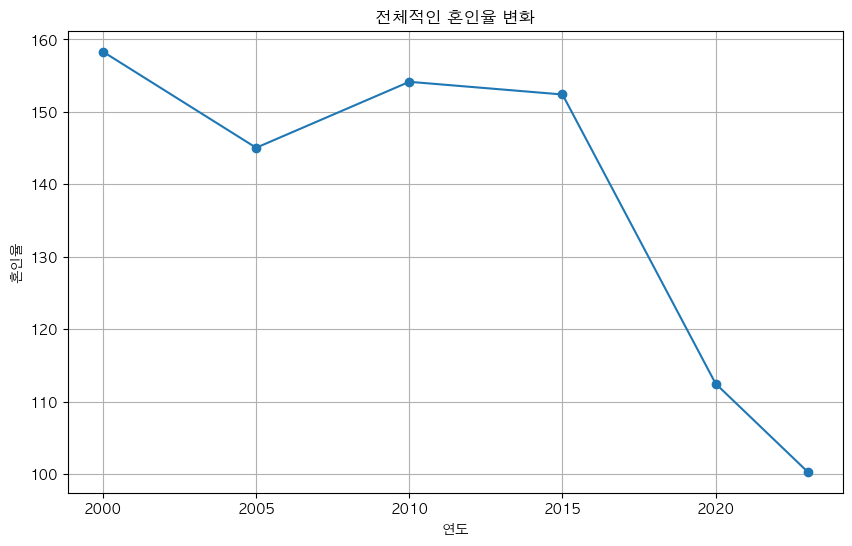

In [36]:
# 전체적인 혼인율 시각화
marriage_data = pd.read_excel('data/경기도_연령대별_혼인율.xlsx')
marriage_data.rename(columns={marriage_data.columns[0]: 'age_group'}, inplace=True)
years = marriage_data.columns[1:]
total_marriage_rate = marriage_data[years].sum(axis=0)

plt.figure(figsize=(10, 6))
plt.plot(years, total_marriage_rate, marker='o', linestyle='-')
plt.title('전체적인 혼인율 변화')
plt.xlabel('연도')
plt.ylabel('혼인율')
plt.grid(True)
plt.show()

### 혼인율과 출산율 변화 한 눈에 보기

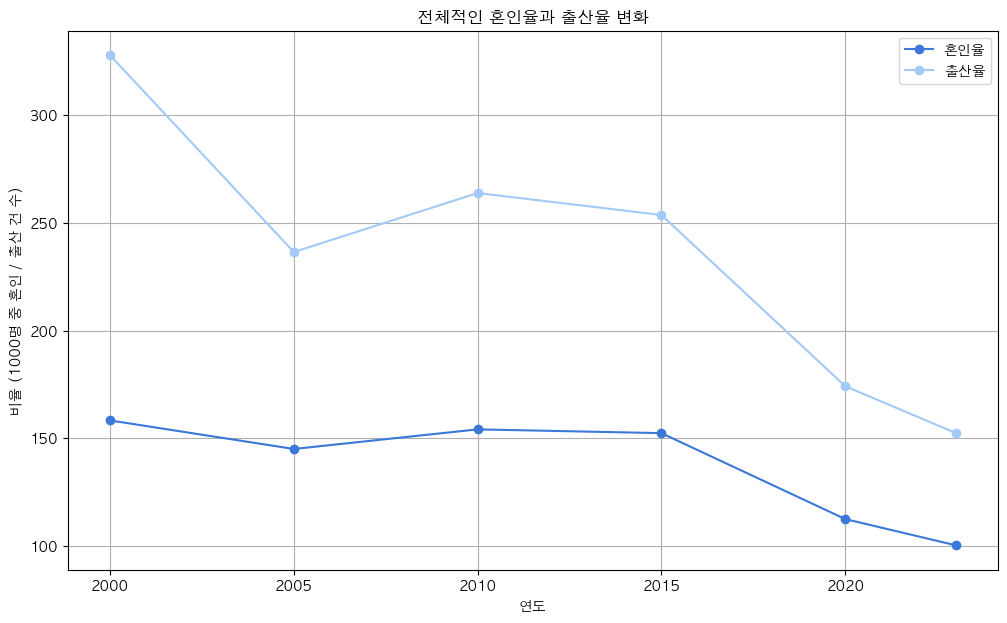

In [37]:
plt.figure(figsize=(12, 7))
plt.plot(years, total_marriage_rate, marker='o', linestyle='-', color='#3c78d8', label='혼인율')
plt.plot(years, total_birth_rate, marker='o', linestyle='-', color='#a3c9f7', label='출산율')
plt.title('전체적인 혼인율과 출산율 변화')
plt.xlabel('연도')
plt.ylabel('비율 (1000명 중 혼인 / 출산 건 수)')
plt.legend()
plt.grid(True)
plt.show()


### 누적바 차트 이용해 출산율과 혼인율의 경향성 비교

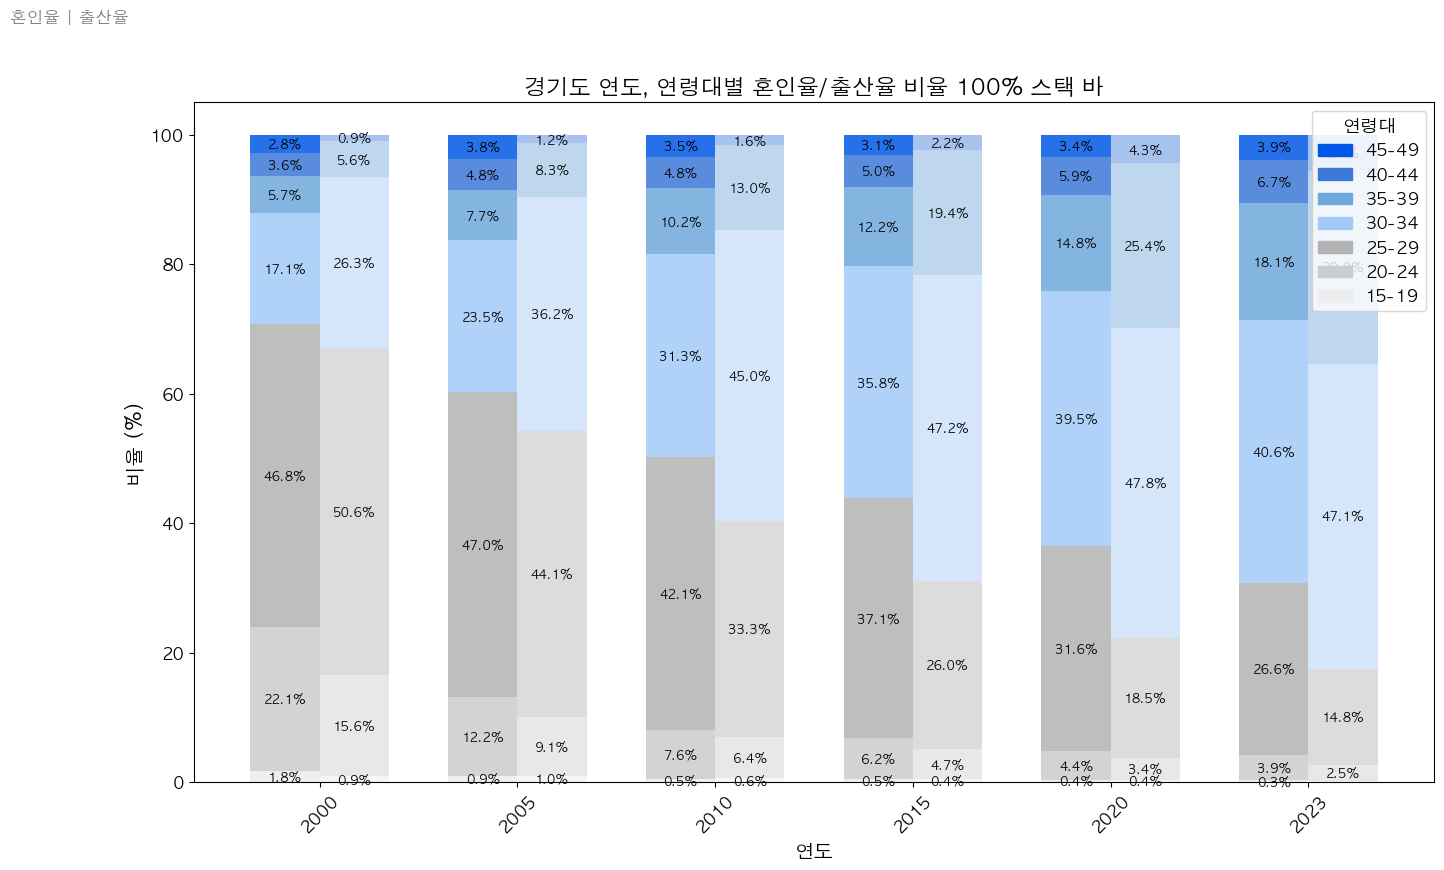

In [38]:
# 1. 연도별 합계로 나누어 비율(%)로 변환
age_order = ['15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49']

df_marriage = pd.read_excel('data/경기도_연령대별_혼인율.xlsx', index_col=0)
df_marriage.index = [a.replace(' ', '').replace('세', '') for a in df_marriage.index]
df_marriage = df_marriage.loc[age_order].T

sum_marriage = df_marriage.sum(axis=1)
marriage_ratio = df_marriage.div(sum_marriage, axis=0) * 100

df_birth = pd.read_excel('data/경기도_연령대별_출산율.xlsx', index_col=0)
df_birth = df_birth.loc[age_order].T
sum_birth = df_birth.sum(axis=1)
birth_ratio = df_birth.div(sum_birth, axis=0) * 100

years = df_marriage.index.astype(int)  # 연도 정수 변환
n_years = len(years)
bar_width = 0.35  # 막대 너비 조정
x = np.arange(n_years)  # x축 위치 생성

colors = custom_palette = [
    "#ededed",  
    "#cccccc",  
    "#b3b3b3",  
    "#a3c9f7",  
    "#6fa8dc", 
    "#3c78d8",  
    "#0057e7",  
]

marriage_ratio = df_marriage.div(sum_marriage, axis=0) * 100
birth_ratio = df_birth.div(sum_birth, axis=0) * 100

bottom1 = np.zeros(n_years)
bottom2 = np.zeros(n_years)

plt.figure(figsize=(16, 10)) 
plt.subplots_adjust(bottom=0.2)
plt.tick_params(axis='both', labelsize=12)

# 혼인율 바 텍스트 추가
for idx, age in enumerate(age_order):
    bars = plt.bar(x - bar_width/2, marriage_ratio[age], width=bar_width, 
                  bottom=bottom1, color=colors[idx], alpha=0.85)
    for bar in bars:
        height = bar.get_height()
        if height >= 0.2:  # 0.2% 이상만 표시
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f'{height:.1f}%', 
                     ha='center', va='center', fontsize=9, color='black')
    bottom1 += marriage_ratio[age]

# 출산율 바 텍스트 추가
for idx, age in enumerate(age_order):
    bars = plt.bar(x + bar_width/2, birth_ratio[age], width=bar_width,
                  bottom=bottom2, color=colors[idx], alpha=0.45)
    for bar in bars:
        height = bar.get_height()
        if height >= 0.2:  # 0.2% 이상만 표시
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_y() + height/2, f'{height:.1f}%',
                     ha='center', va='center', fontsize=9, color='black')
    bottom2 += birth_ratio[age]

plt.xticks(x, years, rotation=45)
plt.xlabel('연도', fontsize=14)
plt.ylabel('비율 (%)', fontsize=14)
plt.title('경기도 연도, 연령대별 혼인율/출산율 비율 100% 스택 바', fontsize=16) 

handles = [plt.Rectangle((0,0),1,1, color=colors[i]) for i in range(len(age_order)-1, -1, -1)]
plt.legend(handles, age_order[::-1], title='연령대', fontsize=12, title_fontsize=13, loc='upper right')

plt.text(0.01, 0.96, '혼인율 | 출산율', transform=plt.gcf().transFigure, fontsize=12, color='gray')

plt.show()